>Authors:
>
> - Zofia Agata Lenarczyk s242916
> - Antoine Paul Louis Aubry s243253
> - Dimitrios Tsiliakidis s243204

This notebook contains the assignment 2 for the course Social Graphs and Interactions 2025.

The content of this notebook focuses on the analysis of the rock music network. It explores the rock music network through backbone and community detection, TF-IDF analysis of Wikipedia texts, and sentiment analysis to understand genre and community structure.

In [197]:
# imports
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import re
import json
from collections import defaultdict, Counter
import pandas as pd
import matplotlib.patches as mpatches
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import sys
from wordcloud import WordCloud
sys.path.append("https://raw.githubusercontent.com/Azri-oss/Social_Graphs_Assignment_1/main/Assignment_2/libs/backboning.py")
import backboning


In the following parts of the notebook, we will refer to the rock music network created in the Assignment 1 and the *bands folder* containing the Wikipedia texts for all  artists.

In [ ]:
url_graph = "https://raw.githubusercontent.com/Azri-oss/Social_Graphs_Assignment_1/main/Assignment_1/Rock_Music_Network.graphml"

r = requests.get(url_graph)
with open("Rock_Music_Network.graphml", "wb") as f:
    f.write(r.content)

graph = nx.read_graphml("Rock_Music_Network.graphml")

In [17]:
url_bands = "https://api.github.com/repos/Azri-oss/Social_Graphs_Assignment_1/contents/Assignment_2/bands"

response_bands = requests.get(url_bands)
files_bands = response_bands.json()

# Part 1: Analyze the network

>* Present an analysis/description of the network of bands/artists using tools from Lecture 5. Imagine that you have been tasked with presenting the important facts about the network to an audience who knows about network science, but doesn't know about this particular network.
   >- It's OK to also use basic concepts like degree distributions (even though they're from week 4) in your analysis. That way you can make the analysis a standalone, coherent thing.
   >- I would like you to include concepts like centrality and assortativity in your analysis.
   >- Use a network backbone in your analysis.
   >- In addition to standard distribution plots (e.g. degree distributions, etc), your analysis should also include at least one network visualization (but it doesn't have to display the entire network, you can also visualize a network backbone).
   >- **Note**: As I write above, an important part of the exercise consists is *selecting the right elements of the lecture* to create a meaningful analysis. So don't solve this part by going exhaustive and just calculating everything you can think of in one massive analysis. Try to focus on using what you've learned to characterize the network. 

# Part 2: Genres and communities and plotting 


>* Write about genres and modularity.
>* Detect the communities, discuss the value of modularity in comparison to the genres.
>* Calculate the matrix $D$ and discuss your findings.
>* Plot the communities and comment on your results.


### **Question 2.1 :** Write about genres and modularity

In this question, we first aim to gather the genres of each artist into a single dictionary called *dict_mapping*. This will allow us to analyze the network through the lens of rock artists genres.

In [9]:
# Because some of the wikipedia pages have different names for a same genre, we need to do a normalization.

GENRE_NORMALIZATION = {
    "rock'n'roll": "rock and roll",
    "rock & roll": "rock and roll",
    "rock&roll": "rock and roll",
    "hip-hop": "hip hop",
    "r&b": "rhythm and blues",
    "rhythm & blues": "rhythm and blues",
    "rnb": "rhythm and blues",
    "r b": "rhythm and blues",
}
def normalize_genre_mapping(genre):
    g = genre.lower().strip()
    g = g.replace("'", "").replace('"', "")
    g = re.sub(r'\s+', ' ', g)
    return GENRE_NORMALIZATION.get(g, g)



In [ ]:
# Regex was done using LLM
def extract_genres_from_wikitext_simple(wikitext):
    """
    Only extract genres from [[...]] just after | genre = ...
    Stop capturing as soon as another field starts (|).
    """
    if not wikitext:
        return []

    genres_found = []

    # delete HTML comments
    text = re.sub(r'<!--.*?-->', '', wikitext, flags=re.DOTALL)
    # only get information after genre= and before "|"
    match = re.search(r'\|\s*genre\s*=\s*((?:.|\n)*?)(?=\n\s*\||<ref>|$|\Z)', text, re.IGNORECASE)
    # if no genre field found
    if not match:
        return []
    # get the block of text after genre=
    block = match.group(1)

    # extract content inside [[...]]
    links = re.findall(r'\[\[([^\]]+)\]\]', block) 
    for link in links:
        # part after "|" if it exists
        genre = link.split('|')[-1].strip().lower()
        # remove parentheses and content inside
        genre = re.sub(r'\(.*?\)', '', genre) 
        # to keep special characters like ä, letters and figures.
        genre = re.sub(r'[^(\w)\s&/-]', ' ', genre) 
        # normalize spaces
        genre = re.sub(r'\s+', ' ', genre).strip() 
        if genre:
            genres_found.append(genre)

    return genres_found



In [ ]:
import requests, zipfile, io, os


def genre_mapping(files_bands):
    dict = {}
    for file_info in files_bands:
        # load file content from GitHub API
        url = file_info['download_url']
        response = requests.get(url)
        data = response.json()
        # get artist name and wikitext from JSON file
        artist = data.get('page','')
        wikitext = data.get('wikitext','')
        genres = extract_genres_from_wikitext_simple(wikitext)
        normalized_genres = [normalize_genre_mapping(g) for g in genres]
        dict[artist] = normalized_genres
    return dict

dict_mapping = genre_mapping(files_bands)

Processing artist: 38_Special_(band)
Processing artist: 10_Years_(band)
Processing artist: 10cc
Processing artist: 311_(band)
Processing artist: 3_Doors_Down
Processing artist: ABBA
Processing artist: AC/DC
Processing artist: AFI_(band)
Processing artist: A_Perfect_Circle
Processing artist: Accept_(band)
Processing artist: Adam_Ant
Processing artist: Aerosmith
Processing artist: Air_Supply
Processing artist: Alanis_Morissette
Processing artist: Alice_Cooper
Processing artist: Alice_Cooper_(band)
Processing artist: Alice_in_Chains
Processing artist: Alter_Bridge
Processing artist: Ambrosia_(band)
Processing artist: America_(band)
Processing artist: Anthrax_(American_band)
Processing artist: April_Wine
Processing artist: Arcade_Fire
Processing artist: Arctic_Monkeys
Processing artist: Asia_(band)
Processing artist: Audioslave
Processing artist: Avenged_Sevenfold
Processing artist: Avril_Lavigne
Processing artist: Awolnation
Processing artist: Bachman–Turner_Overdrive
Processing artist: B

In [ ]:
def stats_genres(dict_mapping):
    count_nodes_with_genres = 0
    sum_genres = 0
    all_genres = []
    hist_genres = {}
    for genres in dict_mapping.values():
        if genres:  # only consider artists with at least one genre
            count_nodes_with_genres += 1
            # keep track of the total number of genres for all artists
            sum_genres += len(genres)
            all_genres.extend([g for g in genres])
            for g in genres:
                hist_genres[g] = hist_genres.get(g, 0) + 1
    # keep distinct genres from all_genres
    distinct_genres = set(all_genres)

    return count_nodes_with_genres, sum_genres/len(dict_mapping), len(distinct_genres), hist_genres


nodes_with_genres, average_genres, distinct_genres_count, genre_distribution = stats_genres(dict_mapping)
print("Statistics on genres:")
print("Number of nodes with genres:", nodes_with_genres)
print("Average number of genres per node:", average_genres)
print("Total distinct genres:", distinct_genres_count)

Statistics on genres:
Number of nodes with genres: 478
Average number of genres per node: 3.5348360655737703
Total distinct genres: 215


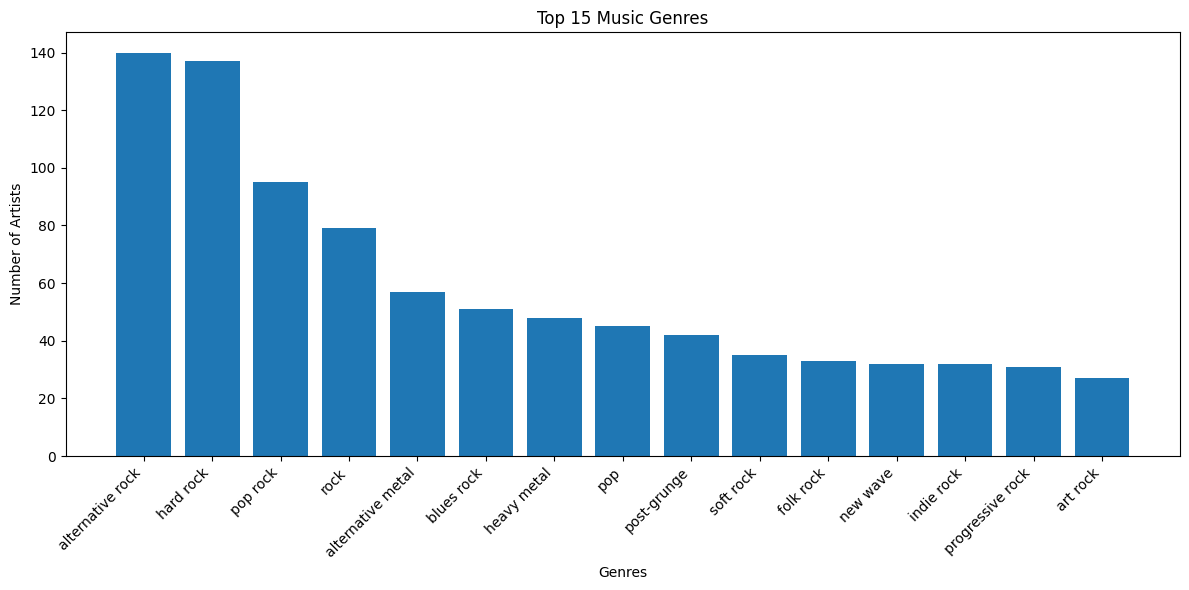

In [27]:
top_genres = sorted(list(genre_distribution.items()), key=lambda x: x[1], reverse=True)[:15]
plt.figure(figsize=(12,6))
plt.bar([x[0] for x in top_genres], [x[1] for x in top_genres])
plt.xlabel("Genres")
plt.ylabel("Number of Artists")
plt.title("Top 15 Music Genres")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

*Observation* : On average, each artist is associated with several genres. Moreover we were surprised by the large number of distinct genres. These two observations reveal that Rock Music is highly diverse, even among its most well known artists.
The histogram also shows that *alternative rock* and *hard rock* are the two predominant genres and that many subgenres of rock exist and play a significant role in the rock music sphere.

**Modularity :** The modularity represents the ability of a graph to have distinct and strong communities. Indeed, by taking into account inter-community and extra community edges, this measure indicates if the graph can be divided into communities and clusters. The following formula gives the modularity of a graph :

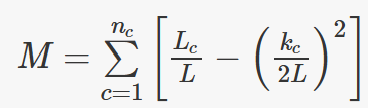

With 
* n<sub>c</sub>: number of communities
* L<sub>c</sub>: number of edges within the community C
* k<sub>c</sub>: total degree of the nodes in the community C
* L: number of edges in the graph

Thus having a better modularity (higher) means that the partition offer a better community structure. Indeed, having **M<=0** reflects a poor partition whereas having **M closer to 1** indicates a stronger community division.

### **Question 2.2 :** Detect the communities, discuss the value of modularity in comparison to the genres.

In [75]:
G_undirected = graph.to_undirected()

def remove_nodes_without_genres(G_undirected, dict_mapping):
    # Identify nodes without genres
    nodes_to_remove = [node for node in G_undirected.nodes() if dict_mapping.get(node)== []]
    print("Nodes to remove:", nodes_to_remove)
    # Remove nodes without genres from graph
    G_undirected.remove_nodes_from(nodes_to_remove)
    return G_undirected
    
remove_nodes_without_genres(G_undirected, dict_mapping)
        

Nodes to remove: ['Electric_Light_Orchestra', 'Poison_(American_band)', 'Dallas_Green_(musician)', 'The_Zombies', 'Pat_Benatar', 'The_Boxtones']


### Create communities based on the genre

For the following part we have decided to use the first listed genre to represent the genre of an artist. Indeed we assume that the genre appearing first on the Wikipedia page is usually the most representative of the artist work.

In [76]:
def label_nodes_by_genre(G_undirected, dict_mapping):
    distinct_genres = []
    for node in G_undirected.nodes():
        # Assign the first genre for the artist
        first_genre = dict_mapping.get(node)[0]
        G_undirected.nodes[node]['genre'] = first_genre
        distinct_genres.append(first_genre)
    distinct_genres = set(distinct_genres)
    return G_undirected, distinct_genres

G_undirected, distinct_genres = label_nodes_by_genre(G_undirected, dict_mapping)
print(G_undirected.nodes(data=True))
print("Distinct genres assigned:", len(distinct_genres))

[('38_Special_(band)', {'genre': 'hard rock'}), ('Jefferson_Starship', {'genre': 'rock'}), ('Peter_Frampton', {'genre': 'rock'}), ('REO_Speedwagon', {'genre': 'arena rock'}), ('Billy_Joel', {'genre': 'rock'}), ('Ted_Nugent', {'genre': 'hard rock'}), ('Lynyrd_Skynyrd', {'genre': 'southern rock'}), ('Bryan_Adams', {'genre': 'rock'}), ('Survivor_(band)', {'genre': 'rock'}), ('Huey_Lewis_and_the_News', {'genre': 'rock'}), ('Bon_Jovi', {'genre': 'hard rock'}), ('Journey_(band)', {'genre': 'arena rock'}), ('Kiss_(band)', {'genre': 'hard rock'}), ('Styx_(band)', {'genre': 'progressive rock'}), ('10cc', {'genre': 'art rock'}), ("Herman's_Hermits", {'genre': 'beat'}), ('Ringo_Starr', {'genre': 'rock'}), ('Queen_(band)', {'genre': 'rock'}), ('George_Harrison', {'genre': 'rock'}), ('Jethro_Tull_(band)', {'genre': 'progressive rock'}), ('Peter_Gabriel', {'genre': 'progressive rock'}), ('The_Police', {'genre': 'new wave'}), ('Toto_(band)', {'genre': 'arena rock'}), ('Asia_(band)', {'genre': 'progre

We lost some information because we went from 215 distinct genres to 80 but we kept the most meaninful.

In [77]:
def create_communities_by_genre(G_undirected):
    # Order nodes by genre
    sorted_nodes_by_genre = sorted(G_undirected.nodes(data=True), key=lambda x: x[1]['genre'])
    list_communities = []
    # Initialize first community
    community = [sorted_nodes_by_genre[0][0]]
    for i in range(1,len(sorted_nodes_by_genre)):
        # Test if genre changed
        if sorted_nodes_by_genre[i][1]['genre'] != sorted_nodes_by_genre[i-1][1]['genre']:
            # New community
            list_communities.append(community)
            community = [sorted_nodes_by_genre[i][0]]
        else:
            community.append(sorted_nodes_by_genre[i][0])
    list_communities.append(community)  # append last community
    return list_communities


list_communities = create_communities_by_genre(G_undirected)
print(list_communities)

[['10_Years_(band)', 'Deftones', 'Mudvayne', 'Faith_No_More', 'Staind', 'Stone_Sour', 'Godsmack', 'Chris_Cornell', 'Tool_(band)', 'Evanescence', 'System_of_a_Down', 'Primus_(band)', 'Drowning_Pool'], ['Barenaked_Ladies'], ['Stone_Temple_Pilots', 'Linkin_Park', '311_(band)', "Jane's_Addiction", 'Incubus_(band)', 'Papa_Roach', 'Morrissey', 'Pearl_Jam', 'My_Chemical_Romance', 'Alanis_Morissette', 'Foo_Fighters', 'Matchbox_Twenty', 'Garbage_(band)', 'Midnight_Oil', 'Pixies_(band)', 'Hoobastank', 'Queens_of_the_Stone_Age', 'Fuel_(band)', 'Gin_Blossoms', 'Beck', 'Cage_the_Elephant', 'Goo_Goo_Dolls', 'Third_Eye_Blind', 'Hole_(band)', 'Coldplay', 'Our_Lady_Peace', 'Awolnation', 'Twenty_One_Pilots', 'A_Perfect_Circle', 'Weezer', 'The_Smashing_Pumpkins', 'Live_(band)', 'R.E.M.', 'Ben_Folds_Five', 'The_Tragically_Hip', 'Muse_(band)', 'Highly_Suspect', 'Jimmy_Eat_World', 'Bloodhound_Gang', 'Blue_October', 'Starset', 'Flyleaf_(band)', 'Cake_(band)', 'Counting_Crows', 'Catfish_and_the_Bottlemen', 'T

In [78]:
def modularity(G_undirected, list_communities):
    modularity = 0
    L= G_undirected.number_of_edges()
    for community in list_communities:
        L_c = G_undirected.subgraph(community).number_of_edges()
        k_c = sum(dict(G_undirected.degree(community)).values())
        M_c = (L_c / L) - (k_c / (2*L))**2
        modularity += M_c
    return modularity

modularity_value = modularity(G_undirected, list_communities)
print("Modularity of the genre-based communities:", modularity_value)

Modularity of the genre-based communities: 0.09663124133677826


The modularity **M=0.09** so the partition is sub-optimal with a positive modularity but far from 1.  It suggests that there is little evidence of strong community structure based on the first genre of each Wikipedia page. It indicates that relying only on genre is insufficient to have a strong community partition.

### Create communities based on the structure of the graph

In [128]:
# Create communities based on the structure of the graph with Louvain Method
list_communities_louvain = nx.community.louvain_communities(G_undirected)
print("Number of communities:", len(list_communities_louvain))

modularity_louvain = modularity(G_undirected, list_communities_louvain)
print("Modularity of Louvain communities:", modularity_louvain)

Number of communities: 4
Modularity of Louvain communities: 0.3419851599666953


We observe we have less communities by using Louvain Method (4-5 instead of 80) and the modularity is much higher so using the structure of the graph instead of genres to create a partition.

### **Question 2.3 :** Calculate the matrix $D$ and discuss your findings

In [129]:
# Assign community labels to nodes based on the louvain partition
# This will be useful for visualization and the confusion matrix
def add_community_labels(G_undirected, partition):
    for node in G_undirected.nodes():
        for i, community in enumerate(partition):
            if node in community:
                # Assign the community label to the node
                G_undirected.nodes[node]['community'] = i
                break   
   
        
add_community_labels(G_undirected, list_communities_louvain)
print(G_undirected.nodes(data=True))

[('38_Special_(band)', {'genre': 'hard rock', 'community': 1, 'all_genres': ['hard rock', 'southern rock', 'boogie rock', 'blues rock']}), ('Jefferson_Starship', {'genre': 'rock', 'community': 1, 'all_genres': ['rock', 'hard rock', 'psychedelic rock', 'progressive rock', 'soft rock']}), ('Peter_Frampton', {'genre': 'rock', 'community': 2, 'all_genres': ['rock']}), ('REO_Speedwagon', {'genre': 'arena rock', 'community': 1, 'all_genres': ['arena rock', 'pop rock', 'hard rock', 'aor', 'blues rock']}), ('Billy_Joel', {'genre': 'rock', 'community': 2, 'all_genres': ['rock', 'soft rock']}), ('Ted_Nugent', {'genre': 'hard rock', 'community': 1, 'all_genres': ['hard rock']}), ('Lynyrd_Skynyrd', {'genre': 'southern rock', 'community': 1, 'all_genres': ['southern rock', 'blues rock', 'country rock', 'hard rock']}), ('Bryan_Adams', {'genre': 'rock', 'community': 2, 'all_genres': ['rock']}), ('Survivor_(band)', {'genre': 'rock', 'community': 1, 'all_genres': ['rock', 'arena rock', 'hard rock']}), 

In [ ]:
# In order to grasp the whole relationship between genres and communities we take into account 
# all genres of each artist instead of only the first one.
def add_all_genres_to_nodes(G_backbone, dict_mapping):
    for node in G_backbone.nodes(data=True):
        if node[0] in dict_mapping:
            node_genres = dict_mapping.get(node[0])
            node[1]['all_genres'] = node_genres
    return G_backbone

add_all_genres_to_nodes(G_undirected, dict_mapping)
print(G_undirected.nodes(data=True))

[('38_Special_(band)', {'genre': 'hard rock', 'community': 0, 'all_genres': ['hard rock', 'southern rock', 'boogie rock', 'blues rock']}), ('Jefferson_Starship', {'genre': 'rock', 'community': 0, 'all_genres': ['rock', 'hard rock', 'psychedelic rock', 'progressive rock', 'soft rock']}), ('Peter_Frampton', {'genre': 'rock', 'community': 1, 'all_genres': ['rock']}), ('REO_Speedwagon', {'genre': 'arena rock', 'community': 0, 'all_genres': ['arena rock', 'pop rock', 'hard rock', 'aor', 'blues rock']}), ('Billy_Joel', {'genre': 'rock', 'community': 1, 'all_genres': ['rock', 'soft rock']}), ('Ted_Nugent', {'genre': 'hard rock', 'community': 0, 'all_genres': ['hard rock']}), ('Lynyrd_Skynyrd', {'genre': 'southern rock', 'community': 0, 'all_genres': ['southern rock', 'blues rock', 'country rock', 'hard rock']}), ('Bryan_Adams', {'genre': 'rock', 'community': 1, 'all_genres': ['rock']}), ('Survivor_(band)', {'genre': 'rock', 'community': 0, 'all_genres': ['rock', 'arena rock', 'hard rock']}), 

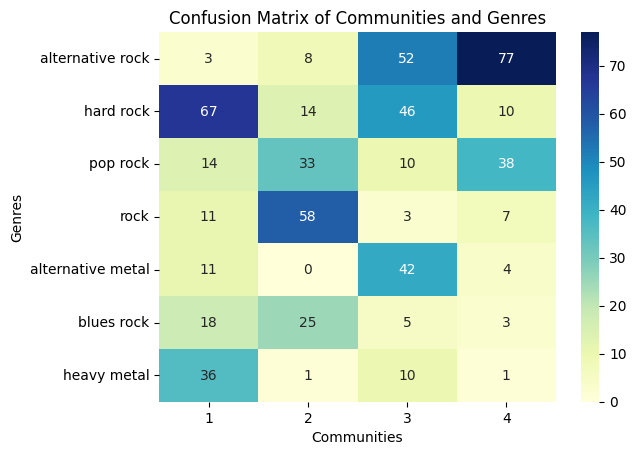

In [105]:
n_communities = len(list_communities_louvain)
n_genres = 7

def confusion_matrix_community_genres(G_backbone,top_genres,nb_communities, nb_genres):
    # Get the top genres
    top_genres_final = top_genres[:nb_genres]
    # Initialise confusion matrix
    confusion_matrix = pd.DataFrame(0, index = range(1,nb_communities+1), columns=[g for g in top_genres_final])
    
    for node in G_backbone.nodes(data=True):
        # Get all genres and community of the node   
        node_genres = node[1].get('all_genres')
        node_community = node[1].get('community')
        for node_genre in node_genres:
        # If the genre is in the top genres and community is assigned we add it to the confusion matrix
            if node_genre in top_genres_final and node_community is not None:
                confusion_matrix.loc[node_community+1,node_genre] += 1
    return confusion_matrix

top_genres_list = [genre[0] for genre in top_genres]  
confusion_matrix =confusion_matrix_community_genres(G_undirected,top_genres_list,n_communities,n_genres)

sns.heatmap(np.transpose(confusion_matrix), annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Genres")
plt.xlabel("Communities")
plt.title("Confusion Matrix of Communities and Genres")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()


The Confusion Matrix changes with each run of the Louvain algorithm. However the same patterns appear at each reload. 
One community (community 2) is mostly composed of **Rock artists** and softer music like pop rock and blues rock. Another one (number 1) groups most of the heavy metal artists along with a wide part of hard rock bands, both representing **aggresive and loud music**. Community 3 seems to gather **alternative artists** (alternative rock/ alternative metal) and hard rock musicians while community 4 is primarly defined by the alternative rock artists.

Using only the fist genre for each artist would have reduced the noise from less prominent genres of artists but it may cause some relationships to be overlooked.

### **Question 2.3 :** Plot the communities and comment on your results

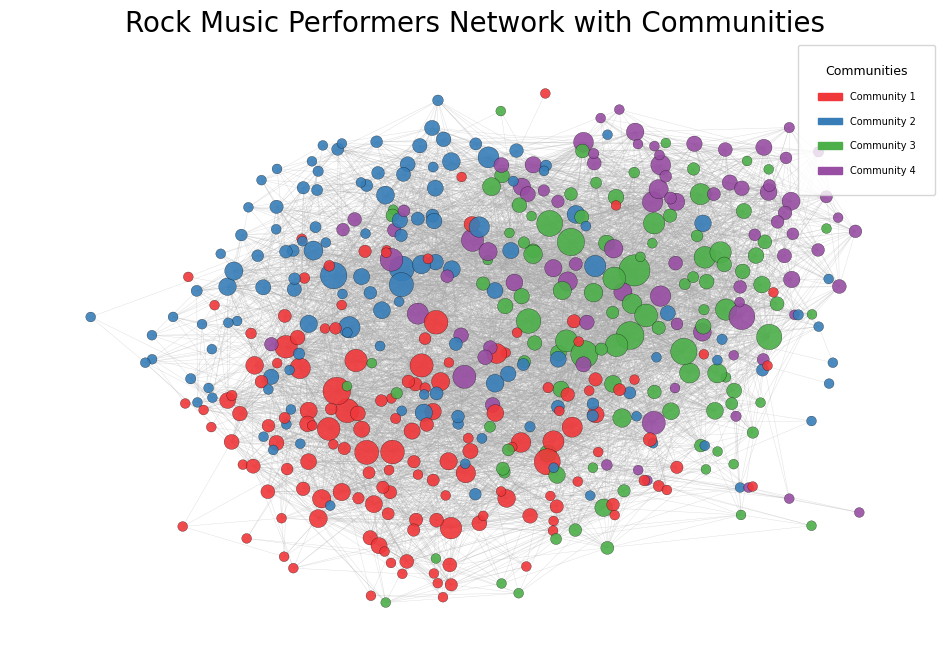

In [154]:
pos = nx.drawing.forceatlas2_layout(G_undirected)

def draw_graph_with_communities(G_undirected, pos, list_communities_louvain, title="Rock Music Performers Network with Communities"):

    # Sort communities by size and keep all communities because they are a few
    partition_sorted = sorted(list_communities_louvain, key=len, reverse=True)
    top_communities = partition_sorted

    # Manage node sizes based on degree
    deg_dict = dict(G_undirected.degree())
    node_sizes = [max(50, d * 4) for d in deg_dict.values()] 

    # Create a mapping from node to community index
    node_to_comm = {}
    for idx, comm in enumerate(top_communities):
        for node in comm:
            node_to_comm[node] = idx

    # Prepare colormap
    n_colors = max(1, len(top_communities))
    custom_colors = [
        "#f0373a",  
        "#377eb8",  
        "#4daf4a", 
        "#984ea3",  
        "#fba34c",  
        "#fbfb50",  
    ]

    # Buils a node color list based on community membership
    node_colors = []
    for node in G_undirected.nodes():
        comm = node_to_comm.get(node)
        if comm is not None and comm < len(custom_colors):
            node_colors.append(custom_colors[comm])
        else:
            node_colors.append("#d3d3d3")
            

    # Create legend entries for each community color
    legend_patches = [
        mpatches.Patch(color=custom_colors[i], label=f"Community {i + 1}")
        for i in range(len(top_communities))
    ]

    # Draw the graph
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G_undirected, pos, node_color=node_colors, node_size=node_sizes, linewidths=0.2, edgecolors='black', alpha=0.9)
    nx.draw_networkx_edges(G_undirected, pos, alpha=0.4, width=0.3, edge_color="#a9a9a9")
    plt.legend(
        handles=legend_patches, 
        title="Communities", 
        fontsize=7,  # Larger font for legend items
        title_fontsize=9,  # Larger font for legend title
        loc='upper right', 
        markerscale=2,  # Increase marker scale for better visibility
        borderpad=2,  # Increase padding inside the legend box
        labelspacing=1.5,  # Increase space between legend items
        handlelength=2.5  # Increase length of color patches
    )
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

draw_graph_with_communities(G_undirected, pos, list_communities_louvain)


It is possible to distinguish the groups formed by each community on the graph, indicating that the partition is relevant. However, we also notice that the communities are not completely distinct and are intertwined, suggesting that the partition is not perfect.

### To achieve better visualization and assess whether the core nodes are well partitioned, we will visualize the backbone graph.

In [158]:

#Model 2
def backboning_graph(G, alpha_thresh):
    # Make sure the graph is undirected
    G_undirected = G.copy() 
    
    edge_betweenness = nx.edge_betweenness_centrality(G_undirected, normalized=False)
    normalized_weights = 1 + (np.array(list(edge_betweenness.values())) - min(edge_betweenness.values())) * (99 / (max(edge_betweenness.values()) - min(edge_betweenness.values())))
    # get edges
    edges = list(G_undirected.edges())

    # build the weights dictionary
    normalized_weights_dict = {
    edge: float(normalized_weights[i]) for i, edge in enumerate(edges)
        }

    # assign weights to edges
    nx.set_edge_attributes(G_undirected, normalized_weights_dict, "weight")

    # Suppose that your graph is G with weights 'weight'
    edges_data = [(u, v, w['weight']) for u, v, w in G_undirected.edges(data=True)]
    df_edges = pd.DataFrame(edges_data, columns=['src', 'trg', 'nij'])

    # Apply the disparity filter
    df_backbone = backboning.disparity_filter(df_edges, undirected=True)
    df_backbone_filtered = df_backbone[df_backbone["score"] < alpha_thresh]


    # To reconstruct a graph from the backbone
    G_backbone = nx.Graph()
    
    for _, row in df_backbone_filtered.iterrows():
        G_backbone.add_edge(row['src'], row['trg'], weight=row['nij'], score=row['score'])
    

    return G_backbone

# Apply backboning with a chosen alpha threshold
alpha_threshold = 0.50
G_backbone = backboning_graph(G_undirected, alpha_threshold)
print("Original number of edges:", G_undirected.number_of_edges())
print("Number of edges in backbone:", G_backbone.number_of_edges())
print("Number of nodes in backbone:", G_backbone.number_of_nodes())

Original number of edges: 5958
Number of edges in backbone: 1755
Number of nodes in backbone: 453


Calculating DF score...


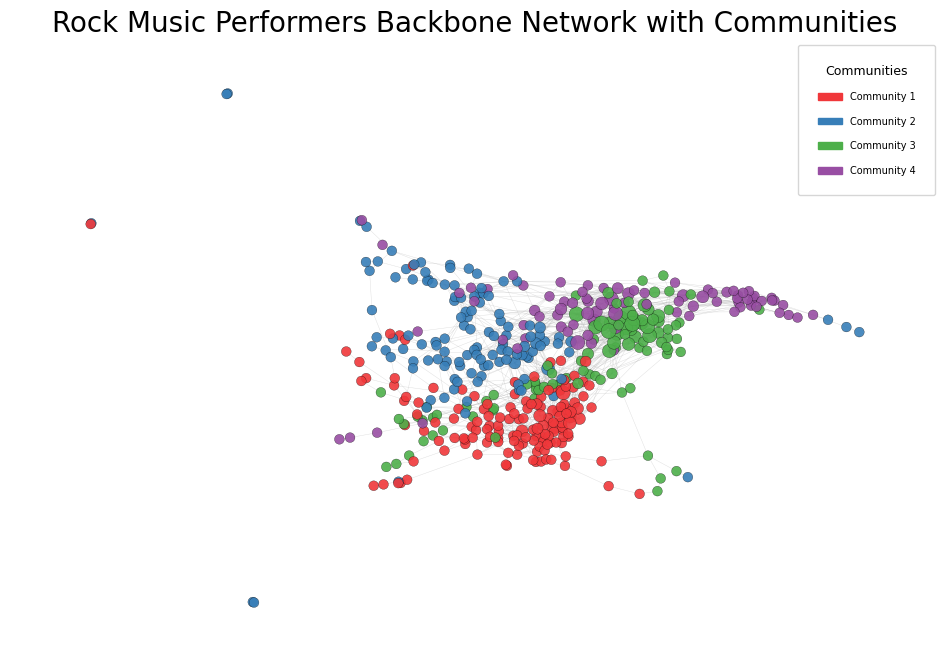

In [ ]:
pos_backbone = nx.drawing.forceatlas2_layout(G_backbone, seed=42)
draw_graph_with_communities(G_backbone, pos_backbone, list_communities_louvain,title="Rock Music Performers Backbone Network with Communities")

By using the backbone graph we notice that despite some errors the communities are much more distinct. For instance, communities 1 and 4 appear to be clearly separate on the remaining nodes.

# Part 3: TF-IDF to understand genres and communities 


>* Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.
>* Calculate and visualize TF-IDF for the genres and communities.
>* Use the matrix $D$ (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.


### **Question 3.1 :** Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.

TF-IDF is a statistical method used to reveal important words in a text within a corpus.
- It is composed of a Term Frequency (TF) : 
$$
    TF(t, d) \;=\; \frac{\text{count}(t, d)}{\sum_{t'} \text{count}(t', d)}
  $$
with : *t* = the word, *d* = the document 
- And an Inverse Document Frequency (IDF) :
$$
    IDF(t) \;=\; \log\!\left(\frac{N}{1 + n_t}\right)
  $$
with : N = number of documents in the corpus collection, ${n_t}$ = number of documents with the word *t*

By combining these two formulas we get TF-IDF : 
$$
    TF\text{-}IDF(t, d) \;=\; TF(t, d) \times IDF(t)
$$
*Interpretation :* A higher TF-IDF value indicates that a word carries greater importance within the document relative to the entire corpus.

### **Question 3.2 :** Calculate and visualize TF-IDF for the genres and communities.

We create two dictionaries within the same function, since reading the bands JSON files from GitHub is time consuming. The first dictionary contains the concatenation of all texts for the communities, and the second contains the concatenation of all texts for the genres. We consider that an artist associated with multiple genres will have their Wikipedia text included under each of the genres they belong to.

In [180]:
def collect_genre_and_community_datasets(G_undirected, top_genres_15,n_communities, files_bands):
    # Initialize dictionaries to hold concatenated texts
    dict_concatenate_text_genres = {genre: [] for genre in top_genres_15}
    dict_concatenate_text_communities = {f"Community_{i}": [] for i in range(1, n_communities + 1)}

    for file_info in files_bands:
        # load file content from GitHub API
        url = file_info['download_url']
        response = requests.get(url)
        data = response.json()
        # get artist name from json file
        artist = data.get('page','')
        # get wikitext from json file
        wikitext = data.get('wikitext','')

        # Check if artist is in the graph
        if artist in G_undirected.nodes():
            # Get all genres of the artist
            all_genres = G_undirected.nodes[artist].get('all_genres', [])
            # Add wikitext to each genre the artist belongs to
            for genre in all_genres:
                if genre in top_genres_15:
                    # Update the wikitext for the genre
                    dict_concatenate_text_genres[genre].append(wikitext)
            # Update the wikitext for the community
            dict_concatenate_text_communities[f"Community_{G_undirected.nodes[artist]['community'] + 1}"].append(wikitext)
            print(artist, "processed.")

    return dict_concatenate_text_genres, dict_concatenate_text_communities

top_genres_15 = [genre[0] for genre in top_genres[:15]]
dict_genres_texts, dict_communities_texts = collect_genre_and_community_datasets(G_undirected, top_genres_15, n_communities, files_bands)

38_Special_(band) processed.
10_Years_(band) processed.
10cc processed.
311_(band) processed.
3_Doors_Down processed.
ABBA processed.
AC/DC processed.
AFI_(band) processed.
A_Perfect_Circle processed.
Accept_(band) processed.
Adam_Ant processed.
Aerosmith processed.
Air_Supply processed.
Alanis_Morissette processed.
Alice_Cooper processed.
Alice_Cooper_(band) processed.
Alice_in_Chains processed.
Alter_Bridge processed.
Ambrosia_(band) processed.
America_(band) processed.
Anthrax_(American_band) processed.
April_Wine processed.
Arcade_Fire processed.
Arctic_Monkeys processed.
Asia_(band) processed.
Audioslave processed.
Avenged_Sevenfold processed.
Avril_Lavigne processed.
Awolnation processed.
Bachman–Turner_Overdrive processed.
Bad_Company processed.
Badfinger processed.
Barenaked_Ladies processed.
Bay_City_Rollers processed.
Beastie_Boys processed.
Beck processed.
Bee_Gees processed.
Ben_Folds_Five processed.
Bill_Haley_&_His_Comets processed.
Billy_Idol processed.
Billy_Joel proces

### Calculation for the genres

In [ ]:

wiki_syntax_stopwords = ['archive', 'cite','category','cite','web','access','url','sfn','bar','nbsp']

# Helper function to replace wiki syntax
def repl_link(m):
        inner = m.group(1)
        if '|' in inner:
            return inner.split('|')[-1]  # text after |
        return inner


def export_genre_word_counts(dict_genres_texts , wiki_syntax_stopwords=wiki_syntax_stopwords):
    """
    Retourne un dictionnaire {genre: "texte complet"} 
    où chaque texte contient tous les wikitexts des artistes de ce genre,
    en minuscule et sans ponctuation.
    """
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))


    genres_data = {}
    for genre, texts in dict_genres_texts.items():
        all_text = " ".join(texts)
        
        # We want to clean the text as much as possible to get significant words and not wiki syntax. 
        # The effect of this work will be reduced by the use of IDF in TF-IDF.

        # Put everything in lowercase
        all_text = all_text.lower()
        # Remove HTML comments
        all_text =re.sub(r'<!--.*?-->', '', all_text, flags=re.DOTALL)
        # Delete links
        all_text = re.sub(r"http\S+|www\S+", " ", all_text)  
        # Delete URL status
        all_text = re.sub(r"url-status\s*=\s*(dead|live)", "", all_text, flags=re.IGNORECASE)
        # Delete wiki fields like "genre ="
        all_text = re.sub(r"\b([a-zA-Z0-9_]+)\s*=","", all_text, flags=re.IGNORECASE) 
        # Remove HTML tags
        all_text = re.sub(r"<.*?>", "", all_text) 
         
        all_text = re.sub(r'\[\[([^\]]+)\]\]', repl_link, all_text)
        # Remove templates
        all_text = re.sub(r'\{\{.*?\}\}', '', all_text, flags=re.DOTALL)
        # Remove digits and punctuation
        all_text = re.sub(r"\d+", " ", all_text)
        # Keep letters
        all_text = re.sub(r"[^\w\s]", " ", all_text)          
        # Replace multiple spaces with a single space
        all_text = re.sub(r"\s+", " ", all_text).strip()
        
        # Tokenize text
        tokens = nltk.word_tokenize(all_text)
        #  Lemmatize and remove stop words and wiki syntax stopwords
        lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word not in wiki_syntax_stopwords]
    
        # Count frequency of words
        word_counts = Counter(lemmatized_tokens)
        
        # Filter words with count < 5 and words with length < 3 because they are not significant
        to_remove = [word for word, count in word_counts.items() if count < 5]
        to_remove_small_words = [word for word in word_counts if len(word) < 3]
        for word in to_remove:
            del word_counts[word]
            
        for word in to_remove_small_words:
            del word_counts[word]
        
        # Term Frequency calculation
        total_words = sum(word_counts.values())
        tf = {word: count / total_words for word, count in word_counts.items()}
        
    
        genre_dict = {word: {"count": count, "tf": tf[word]} for word, count in word_counts.items()}
        sorted_words = dict(sorted(genre_dict.items(), key=lambda x: x[1]["count"], reverse=True))
        genres_data[genre] = sorted_words
        
        print(f"Filtered word counts for {genre}: {len(word_counts)} unique words (count >= 5)")
        print(f"Total words for {genre}: {total_words}")
        
    return genres_data

genres_data = export_genre_word_counts(dict_genres_texts)

Filtered word counts for alternative rock: 7650 unique words (count >= 5)
Total words for alternative rock: 394554
Filtered word counts for hard rock: 7513 unique words (count >= 5)
Total words for hard rock: 383255
Filtered word counts for pop rock: 5975 unique words (count >= 5)
Total words for pop rock: 264241
Filtered word counts for rock: 7114 unique words (count >= 5)
Total words for rock: 324141
Filtered word counts for alternative metal: 4247 unique words (count >= 5)
Total words for alternative metal: 157140
Filtered word counts for blues rock: 3879 unique words (count >= 5)
Total words for blues rock: 126534
Filtered word counts for heavy metal: 4818 unique words (count >= 5)
Total words for heavy metal: 184862
Filtered word counts for pop: 5552 unique words (count >= 5)
Total words for pop: 210453
Filtered word counts for post-grunge: 2588 unique words (count >= 5)
Total words for post-grunge: 80324
Filtered word counts for soft rock: 3195 unique words (count >= 5)
Total wor

In [ ]:
def calculate_idf(genres_data, total_documents):
    
    # Count number of documents containing each word
    document_frequency = defaultdict(int)
    for genre, entry in genres_data.items():
        for word, data in entry.items():
            document_frequency[word] += 1

    # Calculate IDF for each word in each genre
    idf_data = {}
    for genre, entry in genres_data.items():
        idf_dict = {}
        for word in entry.keys():
            df = document_frequency[word]
            # +1 to avoid division by zero (even if not necessary here)
            idf = np.log(total_documents / (1 + df))  
            idf_dict[word] = idf
        idf_data[genre] = idf_dict

    return idf_data
total_documents = len(genres_data)  # Total number of genres considered
idf_data = calculate_idf(genres_data, total_documents)


In [ ]:
def compute_tfidf(genres_data, idf_data):
    tfidf_by_genre = {}
    for genre, entry in genres_data.items():
        tfidf_dict = {}
        for word, data in entry.items():
            tf = data['tf']
            idf = idf_data[genre].get(word, 0)
            tfidf = tf * idf
            tfidf_dict[word] = tfidf
        tfidf_by_genre[genre] = tfidf_dict
    return tfidf_by_genre

tfidf_data = compute_tfidf(genres_data, idf_data)

In [202]:
top_genres_15

['alternative rock',
 'hard rock',
 'pop rock',
 'rock',
 'alternative metal',
 'blues rock',
 'heavy metal',
 'pop',
 'post-grunge',
 'soft rock',
 'folk rock',
 'new wave',
 'indie rock',
 'progressive rock',
 'art rock']

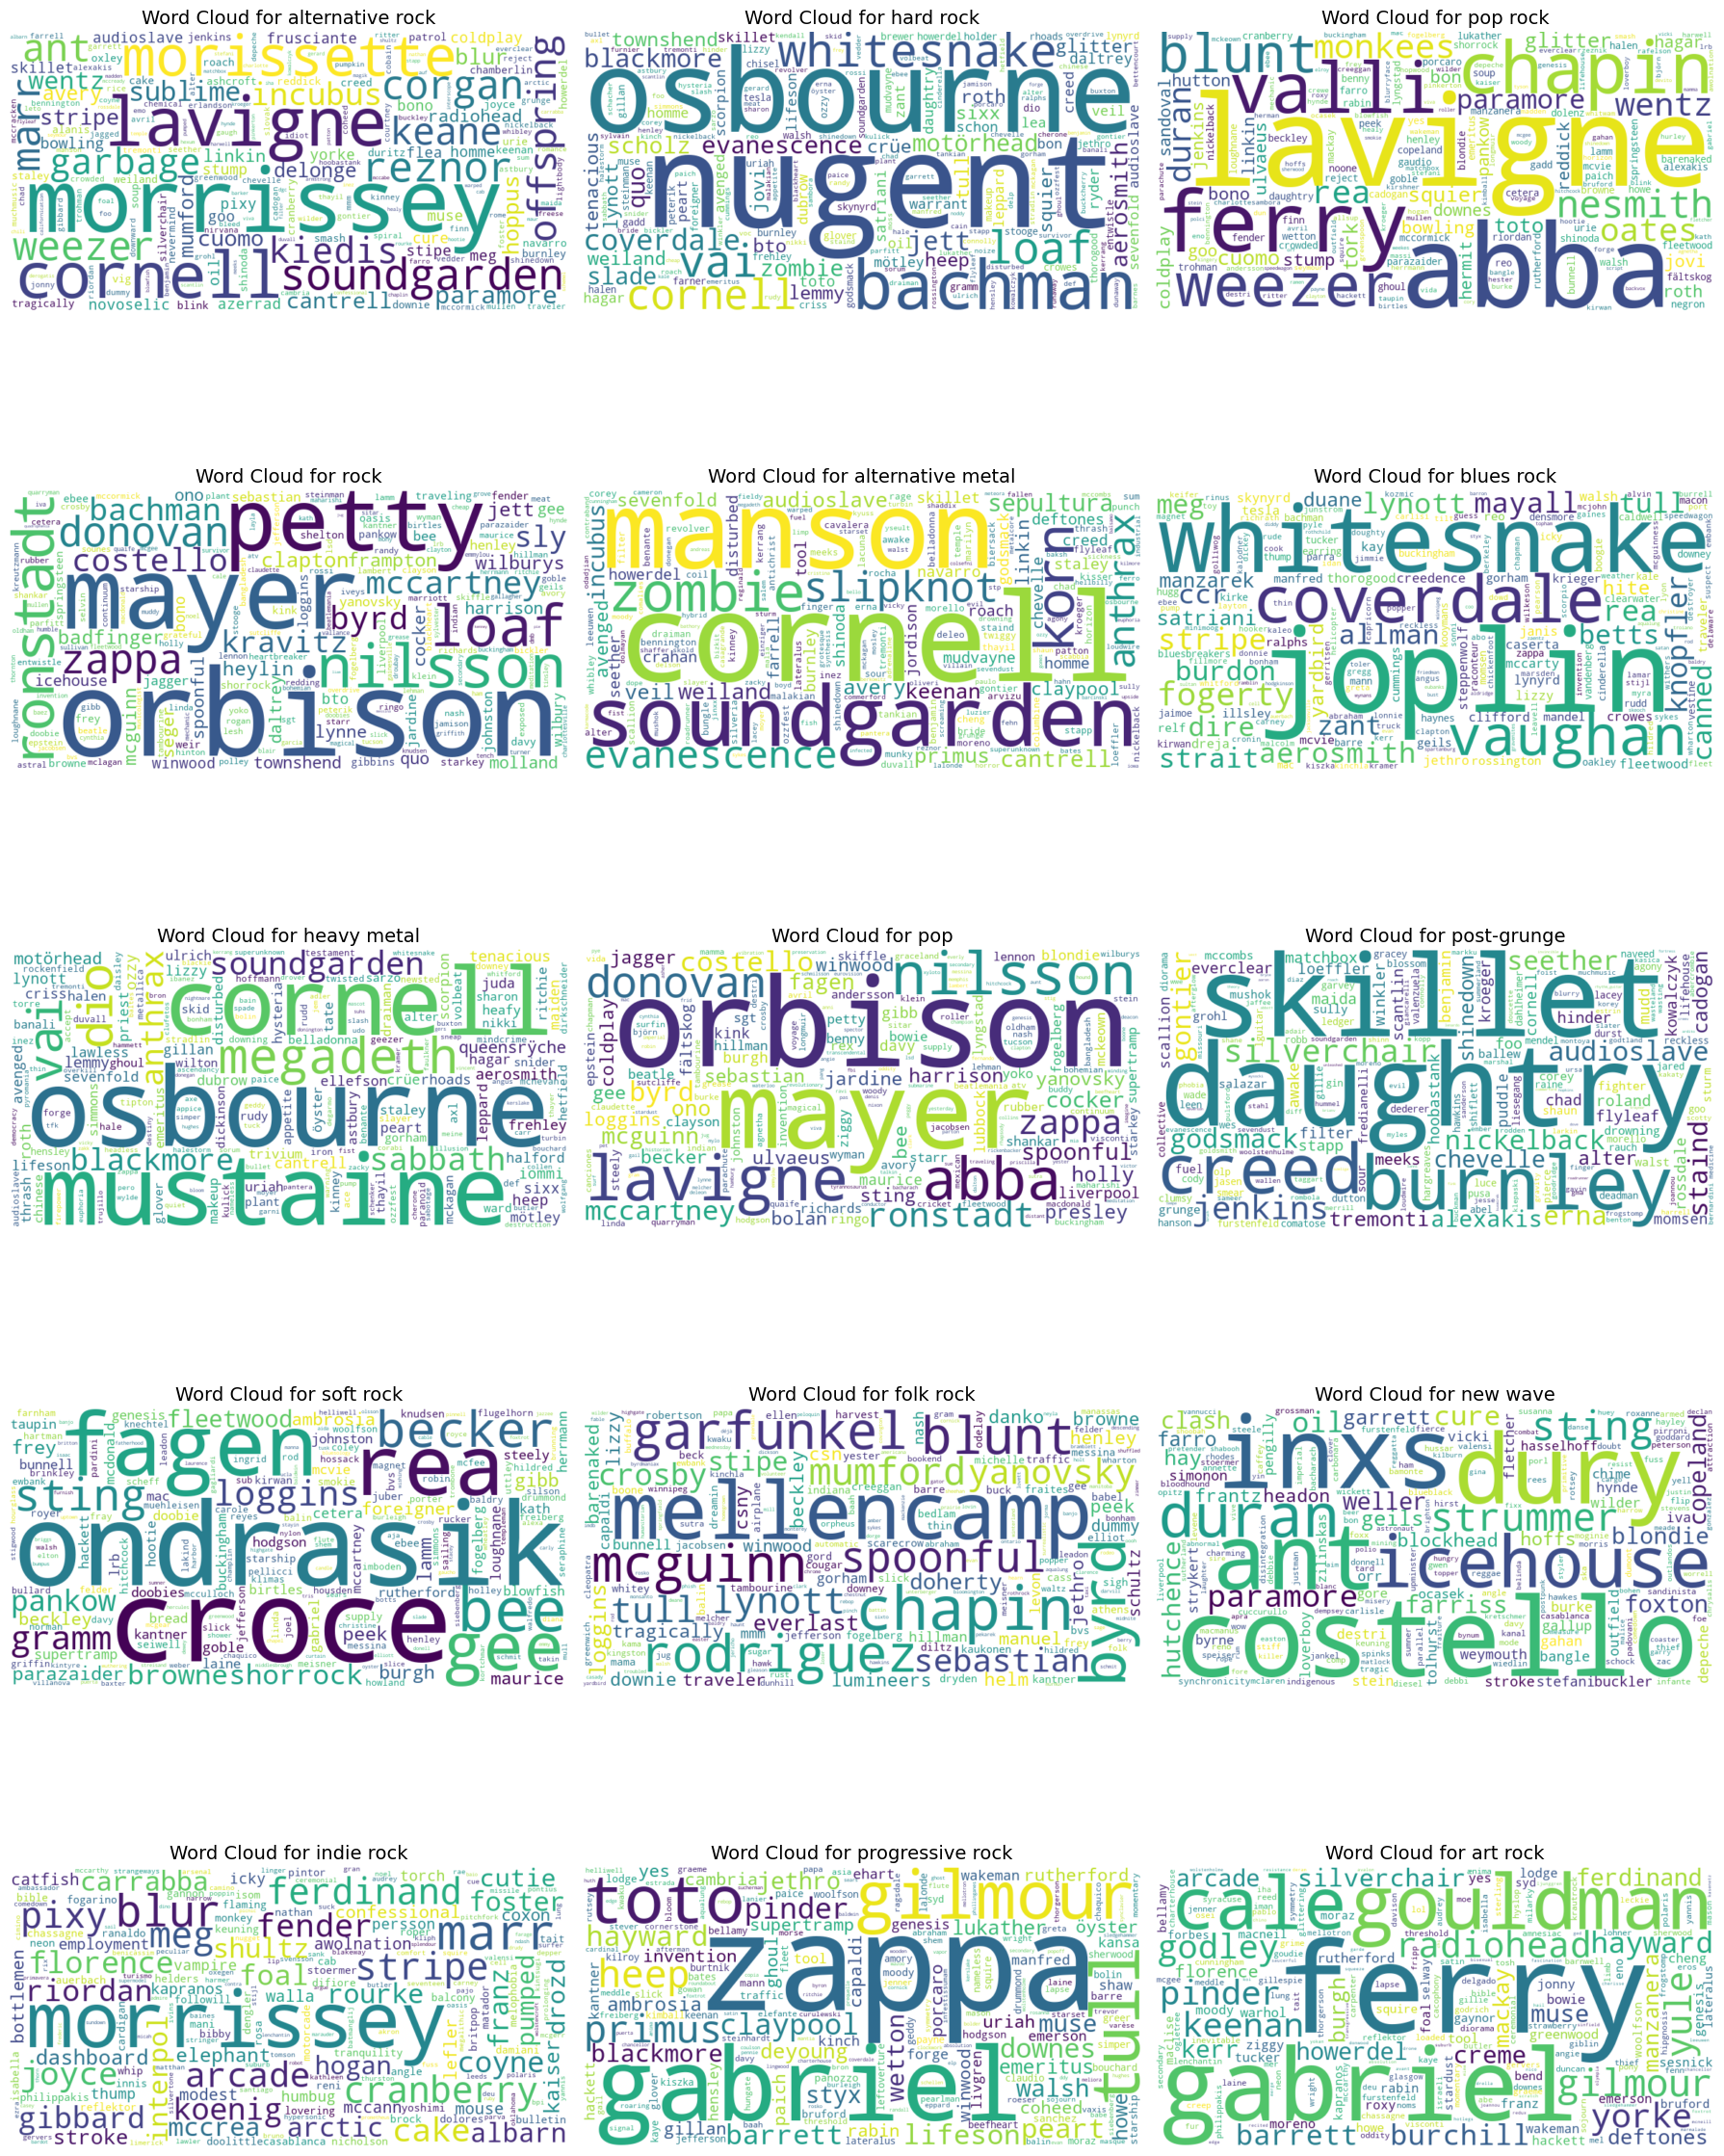

In [ ]:
def plot_wordcloud_for_tfidf(top_genres, tfidf_data, number_rows=5, number_cols=3):

    fig, axes = plt.subplots(number_rows, number_cols, figsize=(18, number_rows * 5))
    axes = axes.flatten()
    
    for i, genre in enumerate(top_genres):
        # Generate word cloud
        wc = WordCloud(width=800, height=400, background_color='white', colormap='viridis', mask=None, collocations=False)
        wc.generate_from_frequencies(tfidf_data[genre])

        # Plot word cloud
        ax = axes[i]
        ax.imshow(wc, interpolation="bilinear")
        ax.set_title(f"Word Cloud for {genre}", fontsize=14)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


plot_wordcloud_for_tfidf(top_genres_15, tfidf_data)

### Calculation for the communities

Filtered word counts for Community_1: 7652 unique words (count >= 5)
Total words for Community_1: 383985
Filtered word counts for Community_2: 6797 unique words (count >= 5)
Total words for Community_2: 320474
Filtered word counts for Community_3: 9353 unique words (count >= 5)
Total words for Community_3: 526946
Filtered word counts for Community_4: 5511 unique words (count >= 5)
Total words for Community_4: 231265


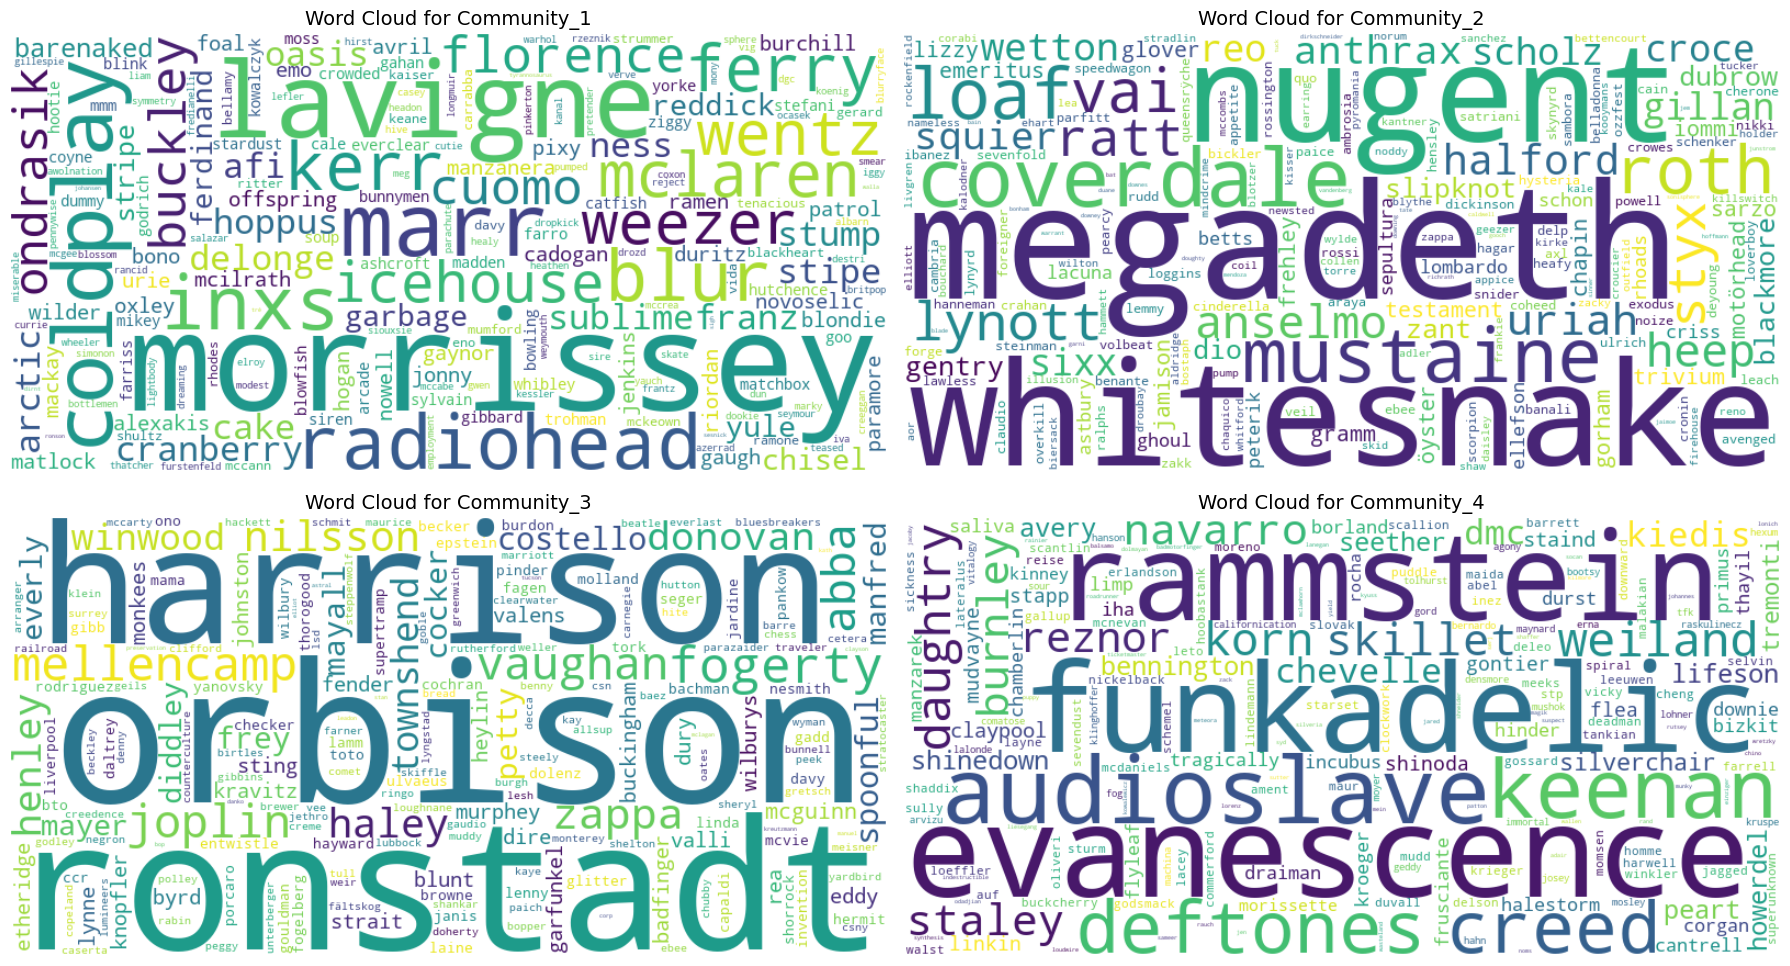

In [203]:
# We can use the same function as those used for genres.

communities_data = export_genre_word_counts(dict_communities_texts)
total_documents_communities = len(communities_data)  # Total number of genres considered
idf_data_communities = calculate_idf(communities_data, total_documents_communities)
tfidf_data_communities = compute_tfidf(communities_data, idf_data_communities)

# Create list of community names to match the logic of the function plot_wordcloud_for_tfidf
top_communities = []
for i in range(n_communities):
    top_communities.append(f"Community_{i+1}")
    
plot_wordcloud_for_tfidf(top_communities, tfidf_data_communities, number_cols=2,number_rows=2)


We notice that in the community and genre word clouds the predominant words are the names of the artists. This is expected, since an artist is frequently mentioned within the Wikipedia pages of other artists in the same genre, and rarely in pages of distant genres. As a result, the term frequency (TF) is relatively high, the inverse document frequency (IDF) is also high, and therefore the TF-IDF score for these artist names is high.

# Part 4: Sentiment of the artists and communities


>* Calculate the sentiment of the band/artist pages (it is OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.
>* Discuss the sentiment of the communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?